In [85]:
import argparse
import os
import pickle

import lightgbm
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
# import optuna.integration.lightgbm as lgb

In [86]:
df = pd.read_csv("./data/desc_canvas_aug30.csv", sep=",")

mols = [Chem.MolFromSmiles(smi) for smi in df['mol']]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in mols]
data = np.array(fps)
target = np.array(df['pIC50'])

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

In [101]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

seed = 42

X = train_data
y = train_target

model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=100)
fit_params = {'verbose': 0,
              'early_stopping_rounds': 30,
              'eval_metric': 'rmse',
              'eval_set': [(X, y)]
              }

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

print(model)

LGBMRegressor(objective='regression', random_state=42)


In [102]:
import optuna
import time
start = time.time()

def objective(trial):
    params = {
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    model.set_params(**params)
    # cross_val_scoreの平均をreturn
    scoring = 'neg_mean_squared_error'
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    return scores.mean()

# 最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=500)

best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'Best params: {best_params}\nBest score: {best_score}')
print(f'Calculation time: {time.time() - start} sec')

[I 2021-11-24 18:21:16,337] A new study created in memory with name: no-name-71f050c2-45ce-4a70-92af-8aae782097bb
[I 2021-11-24 18:21:19,783] Trial 0 finished with value: -0.5434632985303007 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 188, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: -0.5434632985303007.
[I 2021-11-24 18:21:20,792] Trial 1 finished with value: -0.5487035279999712 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 182, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: -0.5434632985303007.
[I 2021-11-24 18:21:21,631] Trial 2 finished with value: -0.7195378706091626 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_lea

[I 2021-11-24 18:21:40,089] Trial 22 finished with value: -0.5421006494947734 and parameters: {'lambda_l1': 0.00029627445129406415, 'lambda_l2': 1.1597766403952754, 'num_leaves': 163, 'feature_fraction': 0.652948454517668, 'bagging_fraction': 0.839482384466971, 'bagging_freq': 5, 'min_child_samples': 21}. Best is trial 18 with value: -0.5297825576308955.
[I 2021-11-24 18:21:41,221] Trial 23 finished with value: -0.5180638168709603 and parameters: {'lambda_l1': 0.006096689116424239, 'lambda_l2': 8.320310494999362, 'num_leaves': 139, 'feature_fraction': 0.572134677896835, 'bagging_fraction': 0.9572784790373746, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 23 with value: -0.5180638168709603.
[I 2021-11-24 18:21:42,515] Trial 24 finished with value: -0.5453993068115285 and parameters: {'lambda_l1': 0.011916790142745142, 'lambda_l2': 0.8304910199967606, 'num_leaves': 126, 'feature_fraction': 0.554773668858355, 'bagging_fraction': 0.9518495807883266, 'bagging_freq': 5, 'min_chil

[I 2021-11-24 18:21:55,487] Trial 45 finished with value: -0.5283447798730799 and parameters: {'lambda_l1': 0.414411493561877, 'lambda_l2': 7.140086549292044e-08, 'num_leaves': 89, 'feature_fraction': 0.5220217634779929, 'bagging_fraction': 0.9238647477943549, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 23 with value: -0.5180638168709603.
[I 2021-11-24 18:21:55,868] Trial 46 finished with value: -0.648278447237221 and parameters: {'lambda_l1': 8.278101352830062e-05, 'lambda_l2': 3.2504463648180185e-05, 'num_leaves': 5, 'feature_fraction': 0.4843712992999459, 'bagging_fraction': 0.8638508170412674, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 23 with value: -0.5180638168709603.
[I 2021-11-24 18:21:56,178] Trial 47 finished with value: -0.5408417880739529 and parameters: {'lambda_l1': 0.04467031803539492, 'lambda_l2': 3.4223695974298116, 'num_leaves': 25, 'feature_fraction': 0.44824689181294336, 'bagging_fraction': 0.9722149019690194, 'bagging_freq': 6, 'min_c

[I 2021-11-24 18:22:04,349] Trial 68 finished with value: -0.8330447736478728 and parameters: {'lambda_l1': 0.16254658807655029, 'lambda_l2': 8.832023917783199e-08, 'num_leaves': 36, 'feature_fraction': 0.4637986106971273, 'bagging_fraction': 0.7361782637331205, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 23 with value: -0.5180638168709603.
[I 2021-11-24 18:22:04,830] Trial 69 finished with value: -0.5320390767282596 and parameters: {'lambda_l1': 0.07742767807357641, 'lambda_l2': 1.9011162086604965, 'num_leaves': 45, 'feature_fraction': 0.847781426191283, 'bagging_fraction': 0.8468244154521348, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 23 with value: -0.5180638168709603.
[I 2021-11-24 18:22:05,222] Trial 70 finished with value: -0.5394675596739166 and parameters: {'lambda_l1': 0.26362452592825963, 'lambda_l2': 2.345077588484925e-06, 'num_leaves': 17, 'feature_fraction': 0.4254434117551782, 'bagging_fraction': 0.8823251498318332, 'bagging_freq': 4, 'min_c

[I 2021-11-24 18:22:14,123] Trial 91 finished with value: -0.5199896679626843 and parameters: {'lambda_l1': 0.27671463182119405, 'lambda_l2': 2.2442679189964233e-08, 'num_leaves': 127, 'feature_fraction': 0.41349366613486077, 'bagging_fraction': 0.8711094727250948, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 90 with value: -0.5077466154219386.
[I 2021-11-24 18:22:14,571] Trial 92 finished with value: -0.5134105774318414 and parameters: {'lambda_l1': 0.5833702537681621, 'lambda_l2': 1.0624133777268524e-08, 'num_leaves': 127, 'feature_fraction': 0.4132290346584725, 'bagging_fraction': 0.86631466391464, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 90 with value: -0.5077466154219386.
[I 2021-11-24 18:22:14,987] Trial 93 finished with value: -0.5103819352737455 and parameters: {'lambda_l1': 0.81243748931216, 'lambda_l2': 2.1759559640007063e-08, 'num_leaves': 127, 'feature_fraction': 0.4002297204622397, 'bagging_fraction': 0.8467008950904932, 'bagging_freq': 6, 'mi

[I 2021-11-24 18:22:23,665] Trial 114 finished with value: -0.5146138159841874 and parameters: {'lambda_l1': 0.09138826831701928, 'lambda_l2': 6.072175507164277, 'num_leaves': 133, 'feature_fraction': 0.41882661293737183, 'bagging_fraction': 0.8190120897445279, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:24,230] Trial 115 finished with value: -0.5222234267344129 and parameters: {'lambda_l1': 0.10868483705757614, 'lambda_l2': 6.185874426124355, 'num_leaves': 132, 'feature_fraction': 0.4120406310237801, 'bagging_fraction': 0.8428089143194428, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:24,616] Trial 116 finished with value: -0.5063699540688187 and parameters: {'lambda_l1': 0.45037154988712214, 'lambda_l2': 3.6547881794723156, 'num_leaves': 123, 'feature_fraction': 0.4216049757692404, 'bagging_fraction': 0.8156231535348442, 'bagging_freq': 6, 'min_c

[I 2021-11-24 18:22:33,417] Trial 137 finished with value: -0.6299665317152783 and parameters: {'lambda_l1': 0.47826916708398703, 'lambda_l2': 0.5425915161642114, 'num_leaves': 115, 'feature_fraction': 0.4660850196057085, 'bagging_fraction': 0.8470222871258686, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:34,021] Trial 138 finished with value: -0.5185490309616247 and parameters: {'lambda_l1': 0.12785311705291352, 'lambda_l2': 1.814430411448815, 'num_leaves': 101, 'feature_fraction': 0.4491322497236784, 'bagging_fraction': 0.8832864718246842, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:34,499] Trial 139 finished with value: -0.5159570729319864 and parameters: {'lambda_l1': 0.0688060593079691, 'lambda_l2': 2.898145277210594, 'num_leaves': 125, 'feature_fraction': 0.41677077108325106, 'bagging_fraction': 0.8256155984618326, 'bagging_freq': 5, 'min_c

[I 2021-11-24 18:22:43,879] Trial 160 finished with value: -0.5202145538281997 and parameters: {'lambda_l1': 0.6239754357382599, 'lambda_l2': 9.09618401583552, 'num_leaves': 140, 'feature_fraction': 0.422957408000061, 'bagging_fraction': 0.798641887680264, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:44,328] Trial 161 finished with value: -0.5297310122360512 and parameters: {'lambda_l1': 0.0874244331171913, 'lambda_l2': 1.6188680574905843, 'num_leaves': 147, 'feature_fraction': 0.4104824613458578, 'bagging_fraction': 0.815040631382895, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:44,797] Trial 162 finished with value: -0.5137306874449431 and parameters: {'lambda_l1': 0.05000027017700052, 'lambda_l2': 2.2086646681286566, 'num_leaves': 129, 'feature_fraction': 0.4004789407886038, 'bagging_fraction': 0.8078281625498975, 'bagging_freq': 6, 'min_child_

[I 2021-11-24 18:22:54,503] Trial 183 finished with value: -0.5200573713022554 and parameters: {'lambda_l1': 0.03466790003071308, 'lambda_l2': 3.058007163909367e-08, 'num_leaves': 138, 'feature_fraction': 0.43526426765335197, 'bagging_fraction': 0.8371988855263144, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:55,037] Trial 184 finished with value: -0.5185835627615416 and parameters: {'lambda_l1': 0.3022709028487092, 'lambda_l2': 6.775750976168486, 'num_leaves': 123, 'feature_fraction': 0.41292037986872776, 'bagging_fraction': 0.8578907454057577, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:22:55,460] Trial 185 finished with value: -0.5312191947531492 and parameters: {'lambda_l1': 0.9712728116334298, 'lambda_l2': 0.019594602781841525, 'num_leaves': 130, 'feature_fraction': 0.425272581236635, 'bagging_fraction': 0.8017360825063569, 'bagging_freq': 6, 'm

[I 2021-11-24 18:23:05,333] Trial 206 finished with value: -0.5113501897461475 and parameters: {'lambda_l1': 0.1635825364159364, 'lambda_l2': 2.272958444153239, 'num_leaves': 119, 'feature_fraction': 0.411593379501216, 'bagging_fraction': 0.7988134354813449, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:05,893] Trial 207 finished with value: -0.5144260055677708 and parameters: {'lambda_l1': 0.14065779422582814, 'lambda_l2': 6.317960880392638, 'num_leaves': 121, 'feature_fraction': 0.41097829506893047, 'bagging_fraction': 0.8805094370265362, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:06,337] Trial 208 finished with value: -0.5159028082412143 and parameters: {'lambda_l1': 0.09957141926418235, 'lambda_l2': 2.559271546177262, 'num_leaves': 120, 'feature_fraction': 0.4097583966590325, 'bagging_fraction': 0.8781594076611321, 'bagging_freq': 6, 'min_chil

[I 2021-11-24 18:23:16,470] Trial 229 finished with value: -0.5130543396839093 and parameters: {'lambda_l1': 0.5539949325630519, 'lambda_l2': 2.5463985713361947, 'num_leaves': 109, 'feature_fraction': 0.40740775656267897, 'bagging_fraction': 0.7942938514085481, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:16,870] Trial 230 finished with value: -0.5246291676546152 and parameters: {'lambda_l1': 0.6205169650691631, 'lambda_l2': 2.5302718495636616, 'num_leaves': 111, 'feature_fraction': 0.40320950323677013, 'bagging_fraction': 0.7844271020246842, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:17,363] Trial 231 finished with value: -0.5210836152917723 and parameters: {'lambda_l1': 0.31708250461411136, 'lambda_l2': 1.5721966239476752, 'num_leaves': 105, 'feature_fraction': 0.4013696834432632, 'bagging_fraction': 0.7932931521620457, 'bagging_freq': 6, 'min_

[I 2021-11-24 18:23:26,245] Trial 252 finished with value: -0.5234272787172051 and parameters: {'lambda_l1': 0.47962497121959163, 'lambda_l2': 4.914376567397223, 'num_leaves': 102, 'feature_fraction': 0.45970952116610425, 'bagging_fraction': 0.8498206287616521, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:26,739] Trial 253 finished with value: -0.5203195443870728 and parameters: {'lambda_l1': 0.871498343198518, 'lambda_l2': 0.00017373547804459583, 'num_leaves': 104, 'feature_fraction': 0.4520800429306099, 'bagging_fraction': 0.837612552647902, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:27,102] Trial 254 finished with value: -0.6367601847361593 and parameters: {'lambda_l1': 0.5766857076943762, 'lambda_l2': 9.936748349734286, 'num_leaves': 96, 'feature_fraction': 0.4441595020040632, 'bagging_fraction': 0.8536542299671597, 'bagging_freq': 2, 'min_ch

[I 2021-11-24 18:23:36,819] Trial 275 finished with value: -0.5174295106596319 and parameters: {'lambda_l1': 0.00037340182674594724, 'lambda_l2': 9.931295901689877, 'num_leaves': 98, 'feature_fraction': 0.4409827430460431, 'bagging_fraction': 0.8963411974115394, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:37,212] Trial 276 finished with value: -0.5268800283440178 and parameters: {'lambda_l1': 0.3290895116439852, 'lambda_l2': 6.480791616524916, 'num_leaves': 113, 'feature_fraction': 0.4320681927441537, 'bagging_fraction': 0.8634571599515349, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:37,765] Trial 277 finished with value: -0.51837177048184 and parameters: {'lambda_l1': 2.359533242326827e-06, 'lambda_l2': 4.825717221175375, 'num_leaves': 102, 'feature_fraction': 0.42303596716204794, 'bagging_fraction': 0.8762234816347035, 'bagging_freq': 6, 'min_c

[I 2021-11-24 18:23:47,963] Trial 298 finished with value: -0.5177571448577799 and parameters: {'lambda_l1': 3.0900943939624506e-08, 'lambda_l2': 9.51730442716848, 'num_leaves': 96, 'feature_fraction': 0.4870785507687174, 'bagging_fraction': 0.8236129952694207, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:48,520] Trial 299 finished with value: -0.5086013828102371 and parameters: {'lambda_l1': 1.852785389101561e-07, 'lambda_l2': 9.98185185755519, 'num_leaves': 100, 'feature_fraction': 0.47907744612974446, 'bagging_fraction': 0.8353686353376005, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:49,043] Trial 300 finished with value: -0.5149260386603327 and parameters: {'lambda_l1': 1.6826128675485817e-07, 'lambda_l2': 9.571568816155228, 'num_leaves': 87, 'feature_fraction': 0.49253044370647536, 'bagging_fraction': 0.8345343661978204, 'bagging_freq': 6, 'm

[I 2021-11-24 18:23:58,315] Trial 321 finished with value: -0.5247037552005477 and parameters: {'lambda_l1': 7.036028395728122e-08, 'lambda_l2': 4.683810534283068, 'num_leaves': 100, 'feature_fraction': 0.4882011367520914, 'bagging_fraction': 0.8075045584938602, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:58,961] Trial 322 finished with value: -0.5388819450324431 and parameters: {'lambda_l1': 2.177124740624327e-07, 'lambda_l2': 2.257546201219265e-06, 'num_leaves': 86, 'feature_fraction': 0.4517566413455007, 'bagging_fraction': 0.8336944673902296, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:23:59,460] Trial 323 finished with value: -0.5160574687556214 and parameters: {'lambda_l1': 5.556272048713897e-08, 'lambda_l2': 3.1890077791193, 'num_leaves': 104, 'feature_fraction': 0.4672532940601379, 'bagging_fraction': 0.8240971693011797, 'bagging_freq': 6, '

[I 2021-11-24 18:24:09,507] Trial 344 finished with value: -0.5265047598848142 and parameters: {'lambda_l1': 3.3753894810328586e-07, 'lambda_l2': 4.700483040207759, 'num_leaves': 110, 'feature_fraction': 0.442238273949813, 'bagging_fraction': 0.7943454153967067, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:09,883] Trial 345 finished with value: -0.513185478588004 and parameters: {'lambda_l1': 6.345698406595706e-07, 'lambda_l2': 9.8037203849826, 'num_leaves': 111, 'feature_fraction': 0.45828947694747263, 'bagging_fraction': 0.8073347902786925, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:10,388] Trial 346 finished with value: -0.5266607863277766 and parameters: {'lambda_l1': 1.3922753980816976e-07, 'lambda_l2': 2.560889055192801, 'num_leaves': 83, 'feature_fraction': 0.5007000989853156, 'bagging_fraction': 0.8116971185200129, 'bagging_freq': 6, 'min

[I 2021-11-24 18:24:19,997] Trial 367 finished with value: -0.5039389528098182 and parameters: {'lambda_l1': 3.089915507080002e-08, 'lambda_l2': 9.91001166153535, 'num_leaves': 113, 'feature_fraction': 0.4884976154127967, 'bagging_fraction': 0.8357208183764641, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:20,438] Trial 368 finished with value: -0.5143136333225364 and parameters: {'lambda_l1': 3.8365645968895965e-08, 'lambda_l2': 9.881598932726703, 'num_leaves': 114, 'feature_fraction': 0.5085358955541304, 'bagging_fraction': 0.8470473482815298, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:20,920] Trial 369 finished with value: -0.5151015380293087 and parameters: {'lambda_l1': 1.0594107475885225e-08, 'lambda_l2': 9.559311338603042, 'num_leaves': 113, 'feature_fraction': 0.5074883524011208, 'bagging_fraction': 0.864080478901487, 'bagging_freq': 6, 'm

[I 2021-11-24 18:24:30,664] Trial 390 finished with value: -0.5279686657261584 and parameters: {'lambda_l1': 7.730364055458168e-07, 'lambda_l2': 6.845128189034136, 'num_leaves': 112, 'feature_fraction': 0.4847848919586355, 'bagging_fraction': 0.8450614396752132, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:31,069] Trial 391 finished with value: -0.5145612517786874 and parameters: {'lambda_l1': 1.866490006856895e-07, 'lambda_l2': 3.765890430712542, 'num_leaves': 102, 'feature_fraction': 0.4430751193369724, 'bagging_fraction': 0.8012719092696765, 'bagging_freq': 6, 'min_child_samples': 9}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:31,412] Trial 392 finished with value: -0.5199087539121772 and parameters: {'lambda_l1': 8.760646461295582e-08, 'lambda_l2': 9.972199573063383, 'num_leaves': 106, 'feature_fraction': 0.47521913363866525, 'bagging_fraction': 0.8320783576742092, 'bagging_freq': 6, '

[I 2021-11-24 18:24:42,776] Trial 413 finished with value: -0.5245036940705686 and parameters: {'lambda_l1': 2.1596697481869104e-07, 'lambda_l2': 1.7787067255135756, 'num_leaves': 116, 'feature_fraction': 0.4782430098966634, 'bagging_fraction': 0.8156566983006689, 'bagging_freq': 6, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:43,121] Trial 414 finished with value: -0.6125971324657616 and parameters: {'lambda_l1': 1.1603424287499317e-07, 'lambda_l2': 9.908295929587025, 'num_leaves': 97, 'feature_fraction': 0.4696801953480442, 'bagging_fraction': 0.8378853449439609, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:43,612] Trial 415 finished with value: -0.516788192289877 and parameters: {'lambda_l1': 1.4885281380985695e-08, 'lambda_l2': 4.857133552113936, 'num_leaves': 107, 'feature_fraction': 0.4298038155228551, 'bagging_fraction': 0.8265662837089427, 'bagging_freq': 6,

[I 2021-11-24 18:24:53,783] Trial 436 finished with value: -0.5232111114657108 and parameters: {'lambda_l1': 3.648406045070523e-08, 'lambda_l2': 7.24054357153731, 'num_leaves': 115, 'feature_fraction': 0.4226557242524111, 'bagging_fraction': 0.7899279873796962, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:54,356] Trial 437 finished with value: -0.5243769958676828 and parameters: {'lambda_l1': 8.237779457452379e-08, 'lambda_l2': 2.1762618695220555, 'num_leaves': 98, 'feature_fraction': 0.45160149649201226, 'bagging_fraction': 0.8274979940768082, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:24:54,966] Trial 438 finished with value: -0.5395355362253985 and parameters: {'lambda_l1': 1.0246122825540208e-08, 'lambda_l2': 0.12011453783159223, 'num_leaves': 110, 'feature_fraction': 0.4379692834396624, 'bagging_fraction': 0.8102251094446729, 'bagging_freq': 6

[I 2021-11-24 18:25:04,013] Trial 459 finished with value: -0.6436647413526613 and parameters: {'lambda_l1': 1.0200944778944164e-05, 'lambda_l2': 4.561842562646709, 'num_leaves': 102, 'feature_fraction': 0.43965148546271576, 'bagging_fraction': 0.8622677975925055, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:25:04,530] Trial 460 finished with value: -0.5133996454882825 and parameters: {'lambda_l1': 0.00405681631912395, 'lambda_l2': 6.30612111687051, 'num_leaves': 97, 'feature_fraction': 0.47784618507042, 'bagging_fraction': 0.8176122859425989, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:25:04,974] Trial 461 finished with value: -0.521688860821711 and parameters: {'lambda_l1': 2.5033790380117016e-07, 'lambda_l2': 4.031958938541547, 'num_leaves': 107, 'feature_fraction': 0.5023946686526526, 'bagging_fraction': 0.8437314061840604, 'bagging_freq': 6, 'min_

[I 2021-11-24 18:25:15,906] Trial 482 finished with value: -0.5240449955178434 and parameters: {'lambda_l1': 1.6653826670363945e-07, 'lambda_l2': 5.13004960172719, 'num_leaves': 95, 'feature_fraction': 0.4104136420042267, 'bagging_fraction': 0.8245267017582918, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:25:16,360] Trial 483 finished with value: -0.5214009077352385 and parameters: {'lambda_l1': 7.658356268748214e-07, 'lambda_l2': 3.43853633865783, 'num_leaves': 154, 'feature_fraction': 0.4740558252639446, 'bagging_fraction': 0.8680344521639181, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 111 with value: -0.4988151753458454.
[I 2021-11-24 18:25:16,853] Trial 484 finished with value: -0.5141120944225319 and parameters: {'lambda_l1': 0.0016239744668333639, 'lambda_l2': 6.596972608373103, 'num_leaves': 117, 'feature_fraction': 0.44584360904681064, 'bagging_fraction': 0.8413102323180195, 'bagging_freq': 6, 'm

Best params: {'lambda_l1': 0.26974952823260706, 'lambda_l2': 6.076804903865695, 'num_leaves': 142, 'feature_fraction': 0.44618333463573706, 'bagging_fraction': 0.837855444448892, 'bagging_freq': 6, 'min_child_samples': 7}
Best score: -0.4988151753458454
Calculation time: 247.88694381713867 sec


In [103]:
print(best_params)
print(best_score)

{'lambda_l1': 0.26974952823260706, 'lambda_l2': 6.076804903865695, 'num_leaves': 142, 'feature_fraction': 0.44618333463573706, 'bagging_fraction': 0.837855444448892, 'bagging_freq': 6, 'min_child_samples': 7}
-0.4988151753458454


In [104]:
def calculate_scores(true, pred):
    scores = {}
    scores = pd.DataFrame({'Corr_Coef': np.corrcoef(true, pred)[0][1],
                          'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

model.set_params(**best_params)
print(model)
model.fit(train_data, train_target)
pred = model.predict(test_data)

scores = calculate_scores(test_target, pred)
print(scores)

LGBMRegressor(bagging_fraction=0.837855444448892, bagging_freq=6,
              feature_fraction=0.44618333463573706,
              lambda_l1=0.26974952823260706, lambda_l2=6.076804903865695,
              min_child_samples=7, num_leaves=142, objective='regression',
              random_state=42)
[LightGBM] [Warning] lambda_l1 is set=0.26974952823260706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26974952823260706
[LightGBM] [Warning] bagging_fraction is set=0.837855444448892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.837855444448892
[LightGBM] [Warning] feature_fraction is set=0.44618333463573706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44618333463573706
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.076804903865695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.076804903865695
        Corr_Coef        R

In [105]:
pprint(scores)

        Corr_Coef        R2       MAE       MSE      RMSE
scores   0.871452  0.758692  0.487522  0.433711  0.658567


In [106]:
from pprint import pprint
pprint(best_params)

{'bagging_fraction': 0.837855444448892,
 'bagging_freq': 6,
 'feature_fraction': 0.44618333463573706,
 'lambda_l1': 0.26974952823260706,
 'lambda_l2': 6.076804903865695,
 'min_child_samples': 7,
 'num_leaves': 142}


LGBMRegressor(bagging_fraction=0.837855444448892, bagging_freq=6,
              feature_fraction=0.44618333463573706,
              lambda_l1=0.26974952823260706, lambda_l2=6.076804903865695,
              min_child_samples=7, num_leaves=142, objective='regression',
              random_state=42)


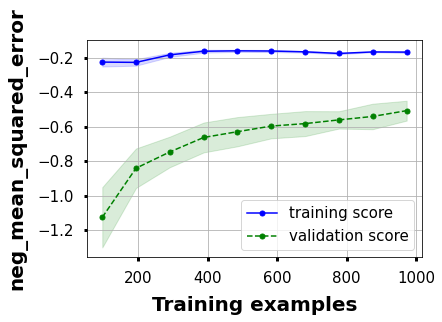

In [107]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
# model.set_params(**best_params)

# 学習曲線の取得
# scoring = 'neg_mean_squared_error'
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=X, y=y,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
#                                                          fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
print(model)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std

fig, ax = plt.subplots()
# training_scoresをプロット
ax.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
ax.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
ax.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
ax.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
# ax.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
#                 color='black', verticalalignment='bottom', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
ax.xaxis.set_tick_params(direction="out", labelsize=15, width=3, pad=10)
ax.yaxis.set_tick_params(direction="out", labelsize=15, width=3, pad=10)
ax.set_xlabel("Training examples", fontsize=20, labelpad=10, weight='bold')
ax.set_ylabel(scoring, fontsize=20, labelpad=10, weight='bold')
ax.legend(fontsize=15)  # 凡例
ax.grid()

In [118]:
optuna.visualization.is_available()

False

In [117]:
import plotly
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [116]:
print(len(train_sizes))
print(len(train_scores))
print(len(valid_scores))

print(train_sizes)
print(train_scores)
print(valid_scores)

10
10
10
[ 97 194 291 389 486 583 681 778 875 973]
[[-0.17579938 -0.23103693 -0.24049437 -0.250001   -0.2239227 ]
 [-0.24211932 -0.25431648 -0.21047456 -0.20555872 -0.21670037]
 [-0.18152375 -0.20127008 -0.16514044 -0.18623523 -0.17774431]
 [-0.1706564  -0.16683845 -0.1655221  -0.15458495 -0.14779401]
 [-0.16235042 -0.16881717 -0.15599941 -0.15429816 -0.15305682]
 [-0.1644251  -0.16883526 -0.16060159 -0.15305077 -0.15311679]
 [-0.17259657 -0.16112803 -0.16013545 -0.16488868 -0.16458058]
 [-0.1771195  -0.17036369 -0.1697118  -0.18112853 -0.17205621]
 [-0.16509161 -0.16827079 -0.16517399 -0.16323492 -0.16447199]
 [-0.16992829 -0.17144458 -0.16212154 -0.1601933  -0.16771587]]
[[-1.22450926 -1.05028621 -1.23076581 -0.81657335 -1.3013617 ]
 [-0.96125378 -0.74227912 -0.9171425  -0.66677054 -0.91248354]
 [-0.7700215  -0.73196888 -0.75429375 -0.59763585 -0.87485499]
 [-0.71804674 -0.59566928 -0.69547787 -0.52958116 -0.76856475]
 [-0.66858054 -0.55838196 -0.6492655  -0.51167218 -0.75248197]
 [-

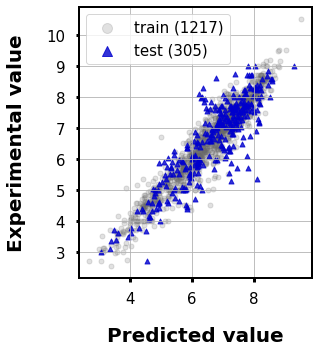

In [109]:
def plot_scatter(values):
    train_target, train_pred, test_target, test_pred = values
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(train_pred, train_target, label=f'train ({len(train_pred)})',
                marker='o', s=25, c='dimgray', alpha=0.2)
    ax.scatter(test_pred, test_target, label=f'test ({len(test_pred)})',
                marker='^', s=25, c='mediumblue', alpha=0.8)
    ax.xaxis.set_tick_params(direction="out", labelsize=15, width=3, pad=10)
    ax.yaxis.set_tick_params(direction="out", labelsize=15, width=3, pad=10)
    ax.set_xlabel("Predicted value", fontsize=20, labelpad=20, weight='bold')
    ax.set_ylabel("Experimental value", fontsize=20, labelpad=20, weight='bold')
    ax.set_aspect('equal')
    ax.legend(fontsize=15, markerscale=2)
    ax.grid()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    return fig


train_pred = model.predict(train_data)
test_pred = model.predict(test_data)
values = train_target, train_pred, test_target, test_pred
fig = plot_scatter(values)
fig.show()

# objectiveを分離？

In [58]:
import argparse
import os
import pickle

from lightgbm import LGBMRegressor
import numpy as np
import optuna
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split


def calculate_scores(true, pred):
    scores = {}
    scores = pd.DataFrame({'Corr_Coef': np.corrcoef(true, pred)[0][1],
                          'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores


def objective(trial, model):
    df = pd.read_csv("./data/desc_canvas_aug30.csv", sep=",")
    mols = [Chem.MolFromSmiles(smi) for smi in df['mol']]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in mols]
    data = np.array(fps)
    target = np.array(df['pIC50'])
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

    seed = 0
    model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=100)
    fit_params = {
        'verbose': 0,
        'early_stopping_rounds': 10,
        'eval_metric': 'rmse',
        'eval_set': [(train_data, train_target)]
        }
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    params = {
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    model.set_params(**params)
    scoring = 'neg_mean_squared_error'
    scores = cross_val_score(model, train_data, train_target, cv=cv,
                            scoring=scoring, fit_params=fit_params, n_jobs=-1)
    return scores.mean()


def main():
#     args = get_parser()
    model = LGBMRegressor(boosting_type='gbdt', objective='regression',
                  random_state=seed, n_estimators=100)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective(trial, model), n_trials=400)
    best_params = study.best_trial.params

    model.set_params(**best_params)
    model.fit(train_data, train_target)
    test_pred = model.predict(test_data)
    scores = calculate_scores(test_target, test_pred).T
    scores.to_csv('lgb_scores.csv')

    # save model
    model_path = "model/"
    os.makedirs(model_path, exist_ok=True)
    model_output_path = os.path.join(model_path, f'{args.output}.pickle')
    with open(model_output_path, mode='wb') as f:
        pickle.dump(model, f)


In [59]:
main()

[I 2021-11-24 13:55:53,798] A new study created in memory with name: no-name-b6dec53a-6768-43ee-a0ca-060fb07c5c83


NameError: name 'trial' is not defined

In [113]:
!pyenv versions

  system
  miniconda3-4.2.12
  miniconda3-4.2.12/envs/calc
  miniconda3-4.2.12/envs/chemts
  miniconda3-4.2.12/envs/home
  miniconda3-4.2.12/envs/pmc
  miniconda3-4.2.12/envs/py27-ADMETlab
  miniconda3-4.2.12/envs/py36-chemts
  miniconda3-4.2.12/envs/py36-chemvae
* miniconda3-4.2.12/envs/py37-chemts (set by PYENV_VERSION environment variable)
  miniconda3-4.2.12/envs/py37-chemvae
  miniconda3-4.2.12/envs/py37-deepchem
  miniconda3-4.2.12/envs/py37-visualization
  miniconda3-4.2.12/envs/tmap
